In [2]:
import sys
import os

# Get the absolute path to the repo root (parent of both src and notebook folders)
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add the repo root to the Python path
sys.path.append(repo_root)

# Now you can import from src
from src.master.data import load_and_crop_data
from src.master.visualize import visualize_masks
from src.master.evaluate import evaluate_binary_masks
from src.master.model import (
    RandomForestClassifier, KNNClassifier, LogRegClassifier, SVMClassifier,
    CLIPEmbedding, HoGEmbedding, ResNET18Embedding
)

In [23]:
from src.master.data import KFoldSegmentationManager

# Define the dataset path
dataset_path = "C:/Users/GustavToft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/sam_inference/processed_data/meatballs"

# Create dataset manager for this specific dataset
dataset_manager = KFoldSegmentationManager(
    dataset_path=dataset_path,
    class_id=1
)

# Print dataset information
print(f"Dataset info: {dataset_manager.get_dataset_info()}")

# Get 5-fold cross validation dataloaders
folds = dataset_manager.get_kfold_dataloaders(k=5, batch_size=1)

# Example: Using with your embedding-classifier framework
print("\nTraining example with first fold:")
train_loader, val_loader = folds[0]

# Get training data directly in the format for classifier.fit()
train_images, train_masks, train_labels = dataset_manager.get_training_data(train_loader)

print(f"Training data prepared:")
print(f"  Images: {len(train_images)}")
print(f"  Shape: {train_images[0].shape}")
print(f"  GT masks: {len(train_masks)}")
print(f"  Shape: {train_masks[0][0].shape}")
print(f"  Labels: {len(train_labels)}")
print(f"  Sample: {train_labels[0]}")


Dataset info: {'dataset_name': 'meatballs', 'class_id': 1, 'total_samples': 200}

Training example with first fold:
Training data prepared:
  Images: 160
  Shape: (270, 250, 3)
  GT masks: 160
  Shape: (270, 250)
  Labels: 160
  Sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


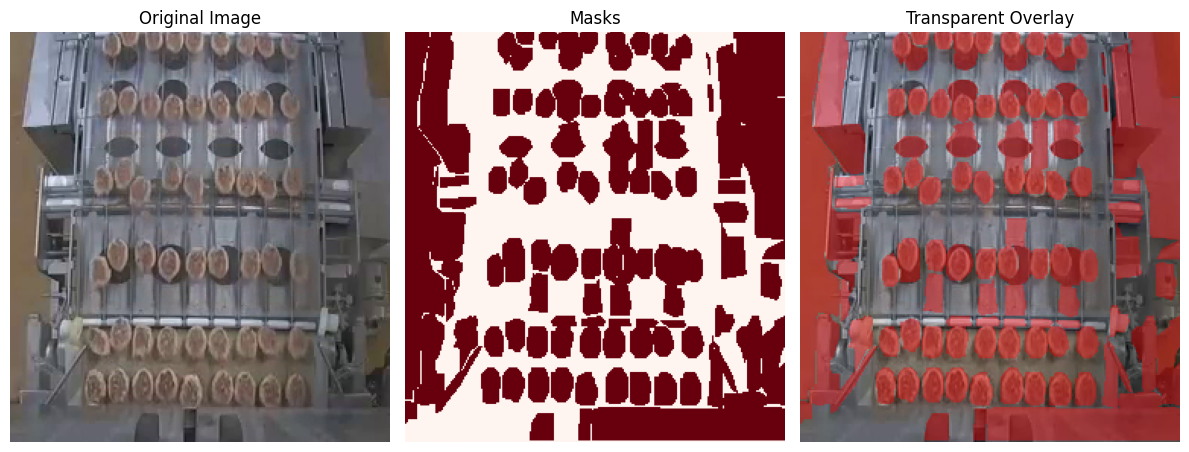

In [24]:
visualize_masks(train_images[0], train_masks[0])

In [25]:
# 1. Create embedding and classifier
config = {
    'clip_model': 'ViT-B/32',
    'use_PCA': True,
    'PCA_var': 0.95
}
embedding = CLIPEmbedding(config)
classifier = SVMClassifier(config, embedding)



Using device: cpu


In [26]:
# 2. Train classifier directly with the data
classifier.fit(train_images[0:1], train_masks[0:1], train_labels[0:1])

Reduced feature dimension from 512 to 52 with 95.0% variance preserved


True

(270, 250, 3)
270


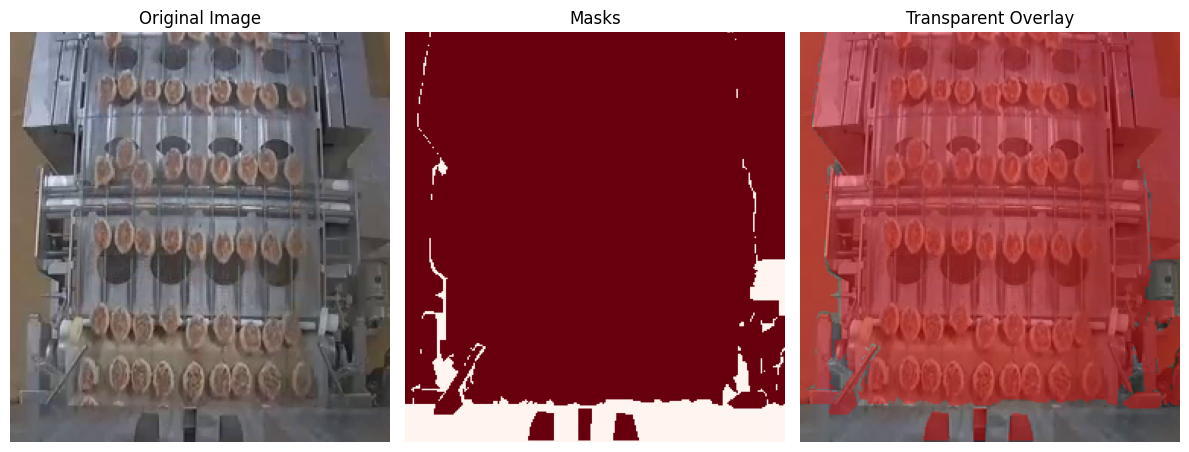

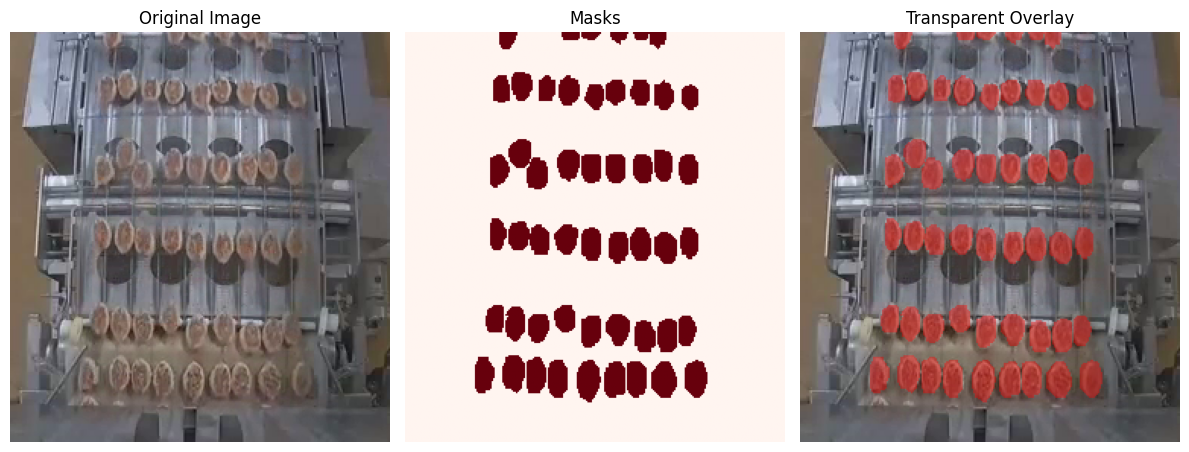

In [27]:
# 3. Get validation data for prediction
validation_data = dataset_manager.get_prediction_data(val_loader)

print(validation_data[0][0].shape)
print(len(validation_data[0][0]))

img, sam, gt = validation_data[0]


visualize_masks(img, sam)
visualize_masks(img, gt)

In [ ]:
import numpy as np
from tqdm import tqdm  # Import tqdm for progress monitoring

# 4. Evaluate on validation data
results_all = []
for image, candidate_masks, gt_masks in tqdm(validation_data, desc="Evaluating"):
    # Predict with classifier
    results_with_classes, probs = classifier.predict(
        image, 
        candidate_masks, 
        return_probabilities=True
    )
    
    # Unpack the results to get just the masks (without the class labels)
    # Assuming results is a list of (mask, class) tuples
    # And we only want masks where class is 1 (positive)
    positive_masks = [mask for mask, class_label in results_with_classes if class_label == 1]
    
    # Now evaluate using just the positive masks
    metrics = evaluate_binary_masks(gt_masks, positive_masks)
    results_all.append(metrics['mask_f1'])

# After the loop, you can calculate overall statistics
mean_f1 = np.mean(results_all)
print(f"Mean F1 score: {mean_f1:.4f}")




Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 40/40 [07:49<00:00, 11.74s/it]

Mean F1 score: 0.9465


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.master.report_generator import SegmentationReportGenerator

# Create a temporary directory for testing
test_output_dir = "test_report_output"
os.makedirs(test_output_dir, exist_ok=True)

# Create mock dataset managers
class MockDatasetManager:
    def __init__(self, name, total_samples, class_id):
        self.name = name
        self.total_samples = total_samples
        self.class_id = class_id
        
    def get_dataset_info(self):
        return {
            "total_samples": self.total_samples,
            "class_id": self.class_id
        }

# Create mock dataset managers - add more datasets for better correlation plots
dataset_managers = {
    "Dataset1": MockDatasetManager("Dataset1", 100, 1),
    "Dataset2": MockDatasetManager("Dataset2", 150, 2),
    "Dataset3": MockDatasetManager("Dataset3", 200, 3),
    "Dataset4": MockDatasetManager("Dataset4", 120, 4)
}

# Create more comprehensive mock results with more embeddings and classifiers
all_results = {
    "per_dataset": {
        "Dataset1": {
            "CLIP": {
                "SVM": {
                    "mask_precision": 0.82,
                    "mask_recall": 0.78,
                    "mask_f1": 0.80,
                    "avg_iou_detected": 0.75,
                    "detected_masks": 78,
                    "total_gt_masks": 100,
                    "avg_training_time": 2.5,
                    "avg_inference_time": 0.3
                },
                "KNN": {
                    "mask_precision": 0.75,
                    "mask_recall": 0.72,
                    "mask_f1": 0.73,
                    "avg_iou_detected": 0.68,
                    "detected_masks": 72,
                    "total_gt_masks": 100,
                    "avg_training_time": 0.8,
                    "avg_inference_time": 0.4
                },
                "RF": {
                    "mask_precision": 0.79,
                    "mask_recall": 0.76,
                    "mask_f1": 0.77,
                    "avg_iou_detected": 0.72,
                    "detected_masks": 76,
                    "total_gt_masks": 100,
                    "avg_training_time": 1.5,
                    "avg_inference_time": 0.25
                }
            },
            "HOG": {
                "SVM": {
                    "mask_precision": 0.68,
                    "mask_recall": 0.65,
                    "mask_f1": 0.66,
                    "avg_iou_detected": 0.61,
                    "detected_masks": 65,
                    "total_gt_masks": 100,
                    "avg_training_time": 1.2,
                    "avg_inference_time": 0.2
                },
                "KNN": {
                    "mask_precision": 0.63,
                    "mask_recall": 0.61,
                    "mask_f1": 0.62,
                    "avg_iou_detected": 0.58,
                    "detected_masks": 61,
                    "total_gt_masks": 100,
                    "avg_training_time": 0.5,
                    "avg_inference_time": 0.3
                }
            },
            "ResNet18": {
                "SVM": {
                    "mask_precision": 0.86,
                    "mask_recall": 0.83,
                    "mask_f1": 0.84,
                    "avg_iou_detected": 0.79,
                    "detected_masks": 83,
                    "total_gt_masks": 100,
                    "avg_training_time": 3.2,
                    "avg_inference_time": 0.45
                },
                "RF": {
                    "mask_precision": 0.81,
                    "mask_recall": 0.79,
                    "mask_f1": 0.80,
                    "avg_iou_detected": 0.75,
                    "detected_masks": 79,
                    "total_gt_masks": 100,
                    "avg_training_time": 2.1,
                    "avg_inference_time": 0.35
                }
            }
        },
        "Dataset2": {
            "CLIP": {
                "SVM": {
                    "mask_precision": 0.88,
                    "mask_recall": 0.85,
                    "mask_f1": 0.86,
                    "avg_iou_detected": 0.82,
                    "detected_masks": 127,
                    "total_gt_masks": 150,
                    "avg_training_time": 2.8,
                    "avg_inference_time": 0.35
                },
                "KNN": {
                    "mask_precision": 0.81,
                    "mask_recall": 0.78,
                    "mask_f1": 0.79,
                    "avg_iou_detected": 0.74,
                    "detected_masks": 117,
                    "total_gt_masks": 150,
                    "avg_training_time": 1.0,
                    "avg_inference_time": 0.45
                }
            },
            "HOG": {
                "SVM": {
                    "mask_precision": 0.72,
                    "mask_recall": 0.69,
                    "mask_f1": 0.70,
                    "avg_iou_detected": 0.65,
                    "detected_masks": 104,
                    "total_gt_masks": 150,
                    "avg_training_time": 1.4,
                    "avg_inference_time": 0.25
                }
            }
        },
        "Dataset3": {
            "CLIP": {
                "SVM": {
                    "mask_precision": 0.85,
                    "mask_recall": 0.82,
                    "mask_f1": 0.83,
                    "avg_iou_detected": 0.78,
                    "detected_masks": 164,
                    "total_gt_masks": 200,
                    "avg_training_time": 3.1,
                    "avg_inference_time": 0.38
                },
                "KNN": {
                    "mask_precision": 0.77,
                    "mask_recall": 0.74,
                    "mask_f1": 0.75,
                    "avg_iou_detected": 0.70,
                    "detected_masks": 148,
                    "total_gt_masks": 200,
                    "avg_training_time": 1.2,
                    "avg_inference_time": 0.5
                }
            },
            "ResNet18": {
                "SVM": {
                    "mask_precision": 0.89,
                    "mask_recall": 0.86,
                    "mask_f1": 0.87,
                    "avg_iou_detected": 0.82,
                    "detected_masks": 172,
                    "total_gt_masks": 200,
                    "avg_training_time": 3.5,
                    "avg_inference_time": 0.48
                }
            }
        },
        "Dataset4": {
            "CLIP": {
                "SVM": {
                    "mask_precision": 0.79,
                    "mask_recall": 0.76,
                    "mask_f1": 0.77,
                    "avg_iou_detected": 0.72,
                    "detected_masks": 91,
                    "total_gt_masks": 120,
                    "avg_training_time": 2.3,
                    "avg_inference_time": 0.32
                }
            },
            "HOG": {
                "SVM": {
                    "mask_precision": 0.65,
                    "mask_recall": 0.62,
                    "mask_f1": 0.63,
                    "avg_iou_detected": 0.58,
                    "detected_masks": 74,
                    "total_gt_masks": 120,
                    "avg_training_time": 1.1,
                    "avg_inference_time": 0.18
                }
            },
            "ResNet18": {
                "SVM": {
                    "mask_precision": 0.83,
                    "mask_recall": 0.80,
                    "mask_f1": 0.81,
                    "avg_iou_detected": 0.76,
                    "detected_masks": 96,
                    "total_gt_masks": 120,
                    "avg_training_time": 2.9,
                    "avg_inference_time": 0.41
                }
            }
        }
    }
}

# Add more detailed training size analysis data
all_results["training_size"] = {
    "Dataset1": {
        "CLIP": {
            "SVM": {
                "2": {"mask_f1": 0.50, "mask_precision": 0.53, "mask_recall": 0.48},
                "5": {"mask_f1": 0.65, "mask_precision": 0.68, "mask_recall": 0.63},
                "10": {"mask_f1": 0.72, "mask_precision": 0.75, "mask_recall": 0.70},
                "20": {"mask_f1": 0.80, "mask_precision": 0.82, "mask_recall": 0.78}
            },
            "KNN": {
                "2": {"mask_f1": 0.45, "mask_precision": 0.47, "mask_recall": 0.43},
                "5": {"mask_f1": 0.60, "mask_precision": 0.62, "mask_recall": 0.58},
                "10": {"mask_f1": 0.68, "mask_precision": 0.70, "mask_recall": 0.66},
                "20": {"mask_f1": 0.73, "mask_precision": 0.75, "mask_recall": 0.72}
            }
        },
        "HOG": {
            "SVM": {
                "2": {"mask_f1": 0.40, "mask_precision": 0.42, "mask_recall": 0.38},
                "5": {"mask_f1": 0.52, "mask_precision": 0.54, "mask_recall": 0.50},
                "10": {"mask_f1": 0.60, "mask_precision": 0.62, "mask_recall": 0.58},
                "20": {"mask_f1": 0.66, "mask_precision": 0.68, "mask_recall": 0.65}
            }
        }
    },
    "Dataset2": {
        "CLIP": {
            "SVM": {
                "2": {"mask_f1": 0.55, "mask_precision": 0.58, "mask_recall": 0.53},
                "5": {"mask_f1": 0.70, "mask_precision": 0.73, "mask_recall": 0.68},
                "10": {"mask_f1": 0.78, "mask_precision": 0.81, "mask_recall": 0.76},
                "20": {"mask_f1": 0.86, "mask_precision": 0.88, "mask_recall": 0.85}
            }
        }
    }
}

# Generate learning curve plots manually for testing
for dataset_name in ["Dataset1", "Dataset2"]:
    for embedding_name in ["CLIP", "HOG"]:
        for classifier_name in ["SVM", "KNN"]:
            if embedding_name in all_results["training_size"].get(dataset_name, {}) and \
               classifier_name in all_results["training_size"].get(dataset_name, {}).get(embedding_name, {}):
                
                plt.figure(figsize=(8, 6))
                train_sizes = sorted([int(k) for k in all_results["training_size"][dataset_name][embedding_name][classifier_name].keys()])
                f1_scores = [all_results["training_size"][dataset_name][embedding_name][classifier_name][str(size)]["mask_f1"] 
                             for size in train_sizes]
                
                plt.plot(train_sizes, f1_scores, 'o-', linewidth=2)
                plt.title(f'Learning Curve: {dataset_name} - {embedding_name} - {classifier_name}')
                plt.xlabel('Training Size')
                plt.ylabel('F1 Score')
                plt.grid(True, linestyle='--', alpha=0.7)
                plt.savefig(os.path.join(test_output_dir, 
                                         f"{dataset_name}_{embedding_name}_{classifier_name}_learning_curve.png"), 
                            dpi=300)
                plt.close()

# Create report generator and generate report
report_generator = SegmentationReportGenerator(test_output_dir)
summary_df = report_generator.generate_full_report(all_results, dataset_managers)

print(f"Report generated in {test_output_dir}")
print("Summary DataFrame shape:", summary_df.shape)

# Create more comprehensive consistency results
consistency_results = {
    "model_consistency": {
        "CLIP_SVM": {
            "embedding": "CLIP",
            "classifier": "SVM",
            "mean_f1": 0.82,
            "cv": 0.05,
            "min_f1": 0.77,
            "max_f1": 0.86,
            "range": 0.09
        },
        "CLIP_KNN": {
            "embedding": "CLIP",
            "classifier": "KNN",
            "mean_f1": 0.76,
            "cv": 0.03,
            "min_f1": 0.73,
            "max_f1": 0.79,
            "range": 0.06
        },
        "HOG_SVM": {
            "embedding": "HOG",
            "classifier": "SVM",
            "mean_f1": 0.66,
            "cv": 0.05,
            "min_f1": 0.63,
            "max_f1": 0.70,
            "range": 0.07
        },
        "ResNet18_SVM": {
            "embedding": "ResNet18",
            "classifier": "SVM",
            "mean_f1": 0.84,
            "cv": 0.04,
            "min_f1": 0.81,
            "max_f1": 0.87,
            "range": 0.06
        }
    },
    "ranking_correlations": {
        "Dataset1-Dataset2": {
            "correlation": 0.85
        },
        "Dataset1-Dataset3": {
            "correlation": 0.78
        },
        "Dataset2-Dataset3": {
            "correlation": 0.92
        },
        "Dataset1-Dataset4": {
            "correlation": 0.75
        },
        "Dataset2-Dataset4": {
            "correlation": 0.82
        },
        "Dataset3-Dataset4": {
            "correlation": 0.88
        }
    }
}

# Add consistency section and plot consistency metrics
report_generator.plot_consistency_metrics(consistency_results)
report_generator.add_consistency_section(consistency_results)

print("Report updated with consistency analysis")

# Calculate rank stability metrics
model_stability = report_generator.analyze_model_rank_stability(summary_df)

# Create rank stability visualizations
report_generator.plot_rank_stability(model_stability)

# Add rank stability section to report
report_generator.add_rank_stability_section(model_stability)

print("Report updated with rank stability analysis")

# List all generated files
print("\nGenerated files:")
for file in sorted(os.listdir(test_output_dir)):
    print(f" - {file}")

Report generated in test_report_output
Summary DataFrame shape: (16, 10)
Report updated with consistency analysis
Report updated with rank stability analysis

Generated files:
 - Dataset1_CLIP_KNN_learning_curve.png
 - Dataset1_CLIP_SVM_learning_curve.png
 - Dataset1_HOG_SVM_learning_curve.png
 - Dataset2_CLIP_SVM_learning_curve.png
 - ablation_report.html
 - ablation_summary.csv
 - dataset_ranking_correlation.png
 - f1_by_dataset.png
 - f1_by_embedding_classifier.png
 - f1_vs_time.png
 - inference_time.png
 - model_consistency_cv.png
 - model_rank_stability.png
 - rank_distribution.png
 - training_time.png


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>